<a href="https://colab.research.google.com/github/HaJunYoo/Audio_Speech_Processing_Study/blob/main/%08Audio_processing_study_record/sample_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import librosa
import librosa.display
import torch
import torchaudio
import IPython.display as ipd


plt.style.use('seaborn-white')


In [2]:
!wget http://suanlab.com/datasets/GeneralMidi.wav

--2023-02-23 13:17:46--  http://suanlab.com/datasets/GeneralMidi.wav
Resolving suanlab.com (suanlab.com)... 52.219.204.20
Connecting to suanlab.com (suanlab.com)|52.219.204.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3409459756 (3.2G) [audio/wav]
Saving to: ‘GeneralMidi.wav’

GeneralMidi.wav     100%[===================>]   3.17G  8.58MB/s    in 6m 24s  

2023-02-23 13:24:11 (8.47 MB/s) - ‘GeneralMidi.wav’ saved [3409459756/3409459756]



In [3]:
midi_file = "./GeneralMidi.wav"

In [4]:
instruments = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

num_notes = 50
sec = 2

audio = []
inst = []
for inst_idx, note in itertools.product(range(len(instruments)), range(num_notes)):
  instrument = instruments[inst_idx]
  offset = (instrument*num_notes*sec) + (note*sec)
  print('instrument: {}, note: {}, offset: {}'.format(instruments, note, offset))
  y, sr = librosa.load(midi_file, sr=None, offset=offset, duration=2.0)
  audio.append(y)
  inst.append(inst_idx)

instrument: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], note: 0, offset: 0
instrument: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], note: 1, offset: 2
instrument: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], note: 2, offset: 4
instrument: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], note: 3, offset: 6
instrument: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], note: 4, offset: 8
instrument: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], note: 5, offset: 10
instrument: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], note: 6, offset: 12
instrument: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], note: 7, offset: 14
instrument: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], note: 8, offset: 16
instrument: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], note: 9, offset: 18
instrument: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], note: 10, offset: 20
instrument: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], note: 11, offset: 22
instrument: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], note: 12, offset: 24
instrument: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], 

In [5]:
audio_mfcc = []

for y in audio:
  ret = librosa.feature.mfcc(y=y, sr=sr)
  audio_mfcc.append(ret)

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9839 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9839 missing from current font.
  font.set_text(s, 0, flags=flags)


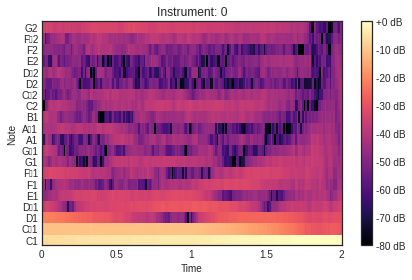

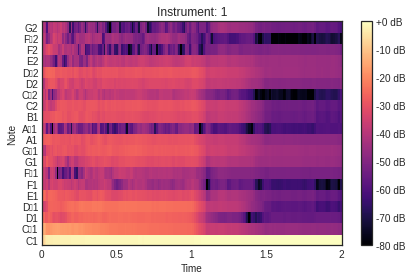

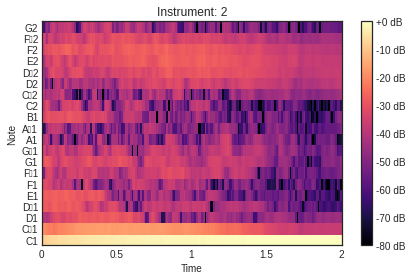

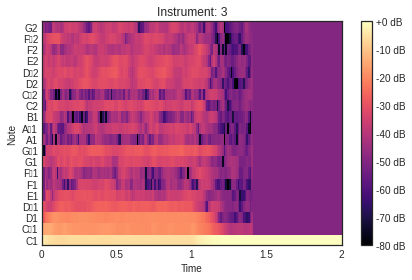

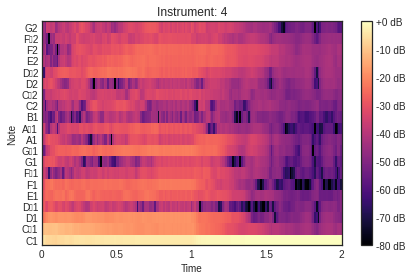

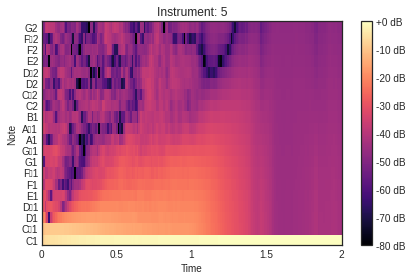

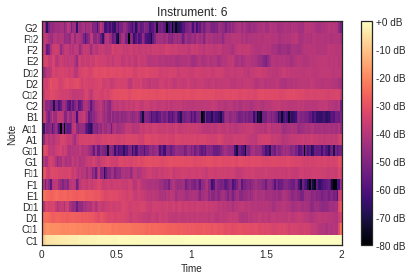

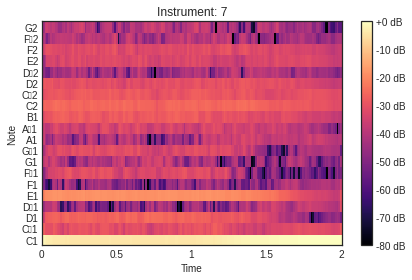

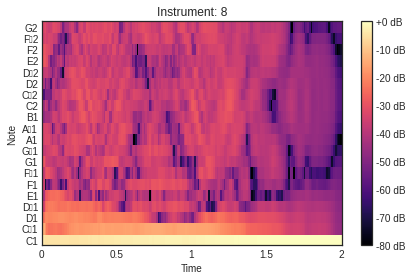

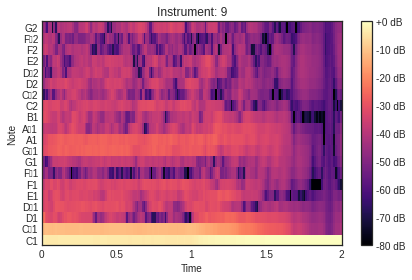

In [6]:
for i in range(0, len(instruments)*num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_mfcc[i]), ref= np.max)
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Instrument: {}'.format(inst[i]))
  plt.tight_layout()
  plt.show()

In [7]:
import numpy as np

audio_np = np.array(audio, np.float32)
inst_np = np.array(inst, np.int16)

print(audio_np.shape, inst_np.shape)

(500, 88200) (500,)


In [8]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_array = np.expand_dims(mfcc_np, -1) # (500, 20, 173, 1)
inst_cat = to_categorical(inst_np) # 원 핫 라벨링

train_x, test_x, train_y, test_y = train_test_split(mfcc_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 20, 173, 1)
(100, 20, 173, 1)
(400, 10)
(100, 10)


In [9]:
mel_spectrogram = mfcc_array[0]
mel_spectrogram.shape

(20, 173, 1)

In [11]:
input_shape = mel_spectrogram.shape

### 모델 1. 과적합이 제일 적으면서 정확도가 제일 무난하게 나오는 모델

In [24]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Reshape, Conv2D, MaxPooling2D, Flatten

model = Sequential()

# Add a convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

# Add a max pooling layer with a 2x2 window
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolutional layer with 64 filters and a 3x3 kernel
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a third convolutional layer with 128 filters and a 3x3 kernel
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

# Add a reshape layer to convert the output of the convolutional layers to the input shape for the LSTM layer
# unfolding
model.add(Reshape((-1, 128)))

# Add an LSTM layer with 64 units
model.add(LSTM(64, return_sequences=True))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# flatten the layer to adapt fc layer
model.add(Flatten())
# Add a dense layer with 10 units and softmax activation for classification
model.add(Dense(10, activation='softmax'))
# Print the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 18, 171, 32)       320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 9, 85, 32)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 83, 64)         18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 3, 41, 64)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 39, 128)        73856     
                                                                 
 reshape_3 (Reshape)         (None, 39, 128)          

이 구현은 마지막 Conv2D 계층에 대해 더 작은 커널 크기를 사용하여 출력 치수를 LSTM 입력에 대해 호환 가능한 모양으로 줄입니다. 마지막 Conv2D 레이어의 출력 형상은 (5, 21, 128)이며, LSTM 레이어에 대한 입력 형상과 동일한 개수의 단위를 갖는다. 그런 다음 reshape 레이어는 컨볼루션 레이어의 출력을 (5*21, 128)의 형상으로 평탄화하는데, 이는 LSTM 레이어에 대한 입력 형상이다.

In [13]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [14]:
# Train the model on the extracted feature vectors
# train_x, test_x, train_y, test_y
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=20, batch_size=128)

Epoch 1/20
4/4 [==============================] - 13s 310ms/step - loss: 2.5758 - accuracy: 0.1075 - val_loss: 2.3003 - val_accuracy: 0.1500
Epoch 2/20
4/4 [==============================] - 0s 21ms/step - loss: 2.3845 - accuracy: 0.1400 - val_loss: 2.1637 - val_accuracy: 0.2200
Epoch 3/20
4/4 [==============================] - 0s 22ms/step - loss: 2.2247 - accuracy: 0.1650 - val_loss: 2.0299 - val_accuracy: 0.3000
Epoch 4/20
4/4 [==============================] - 0s 22ms/step - loss: 2.0195 - accuracy: 0.2625 - val_loss: 1.9070 - val_accuracy: 0.3400
Epoch 5/20
4/4 [==============================] - 0s 22ms/step - loss: 1.8369 - accuracy: 0.3600 - val_loss: 1.9608 - val_accuracy: 0.3300
Epoch 6/20
4/4 [==============================] - 0s 21ms/step - loss: 1.8603 - accuracy: 0.3050 - val_loss: 1.7464 - val_accuracy: 0.4500
Epoch 7/20
4/4 [==============================] - 0s 22ms/step - loss: 1.6632 - accuracy: 0.4225 - val_loss: 1.5504 - val_accuracy: 0.4700
Epoch 8/20
4/4 [=========

In [15]:
def plot_history(history_dict):
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(loss)+1)
  fig = plt.figure(figsize = (14, 5))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(epochs, loss, 'b--', label='train_loss')
  ax1.plot(epochs, val_loss, 'r:', label='val_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']

  epochs = range(1, len(loss)+1)
  fig = plt.figure(figsize = (14, 5))

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.plot(epochs, acc, 'b--', label='train_accuracy')
  ax2.plot(epochs, val_acc, 'r:', label='val_accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('acc')
  ax2.grid()
  ax2.legend()

  plt.show()

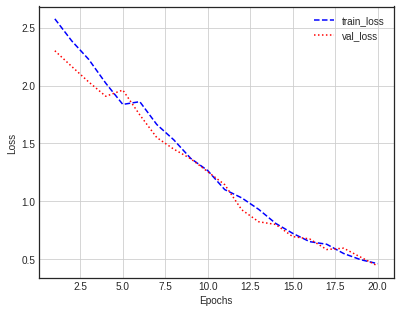

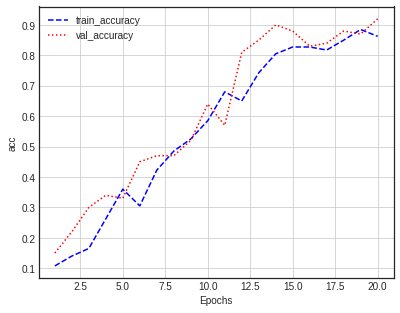

In [18]:
plot_history(history.history)

BatchNormalization와 Lstm 레이어를 늘리게 되면 train data set에 overfit 하는 현상이 발생


각 컨볼루션 레이어 다음에 배치 정규화 레이어를 추가하고 LSTM 유닛과 레이어의 수를 늘렸다. 또한 더 안정적인 훈련을 위해 Adam Optimizer에 학습률을 추가.

In [37]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Reshape, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.optimizers import Adam

model = Sequential()

# Add a convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())

# Add a max pooling layer with a 2x2 window
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolutional layer with 64 filters and a 3x3 kernel
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a third convolutional layer with 128 filters and a 3x3 kernel
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

# Add a reshape layer to convert the output of the convolutional layers to the input shape for the LSTM layer
model.add(Reshape((-1, 128)))

# Add an LSTM layer with 128 units
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

# Add another LSTM layer with 64 units
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))

# Add a dense layer with 10 units and softmax activation for classification
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 18, 171, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 18, 171, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 9, 85, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 7, 83, 64)         18496     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 83, 64)        256       
 hNormalization)                                                 
                                                      

각 컨볼루션 레이어 후 배치 정규화를 사용하여 훈련 안정성을 높이고 잠재적으로 성능을 향상시키는 것을 고려하십시오.
더 많은 LSTM 계층을 추가하거나 LSTM 단위의 수를 늘려 입력에서 더 복잡한 시간 종속성을 캡처할 수 있습니다.
서로 다른 탈락률로 실험하여 과적합을 방지하기 위한 최적의 값을 찾습니다.
모델 일반화를 더욱 개선하기 위해 학습 속도 일정 또는 다른 형태의 정규화를 사용하는 것을 고려해 보십시오.

In [38]:
# Train the model on the extracted feature vectors
# train_x, test_x, train_y, test_y
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=20, batch_size=128)

Epoch 1/20
4/4 [==============================] - 14s 1s/step - loss: 2.0845 - accuracy: 0.2850 - val_loss: 2.2211 - val_accuracy: 0.1200
Epoch 2/20
4/4 [==============================] - 4s 987ms/step - loss: 1.4157 - accuracy: 0.6250 - val_loss: 2.0523 - val_accuracy: 0.2100
Epoch 3/20
4/4 [==============================] - 6s 1s/step - loss: 0.9872 - accuracy: 0.7500 - val_loss: 2.0118 - val_accuracy: 0.2600
Epoch 4/20
4/4 [==============================] - 3s 772ms/step - loss: 0.6630 - accuracy: 0.8400 - val_loss: 2.1474 - val_accuracy: 0.2800
Epoch 5/20
4/4 [==============================] - 3s 800ms/step - loss: 0.4433 - accuracy: 0.9150 - val_loss: 2.1099 - val_accuracy: 0.3100
Epoch 6/20
4/4 [==============================] - 5s 1s/step - loss: 0.3098 - accuracy: 0.9375 - val_loss: 2.0832 - val_accuracy: 0.3500
Epoch 7/20
4/4 [==============================] - 3s 793ms/step - loss: 0.1748 - accuracy: 0.9600 - val_loss: 2.1344 - val_accuracy: 0.2700
Epoch 8/20
4/4 [============

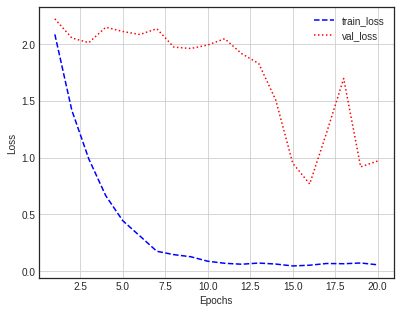

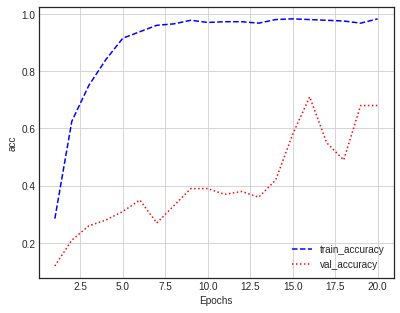

In [39]:
plot_history(history.history)

In [40]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Reshape, Conv2D, MaxPooling2D, Flatten

model = Sequential()

# Add a convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

# Add a max pooling layer with a 2x2 window
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolutional layer with 64 filters and a 3x3 kernel
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a third convolutional layer with 128 filters and a 3x3 kernel
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a reshape layer to convert the output of the convolutional layers to the input shape for the LSTM layer
model.add(Reshape((-1, 128)))

# Add an LSTM layer with 128 units and return sequences
model.add(LSTM(128, return_sequences=True))

# Add another dropout layer
model.add(Dropout(0.5))

# Add another LSTM layer with 64 units and return sequences
model.add(LSTM(64, return_sequences=True))

# Add another dropout layer
model.add(Dropout(0.5))

# Add a final LSTM layer with 32 units
model.add(LSTM(32))

# Add a dense layer with 10 units and softmax activation for classification
model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 18, 171, 32)       320       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 9, 85, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 7, 83, 64)         18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 3, 41, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 1, 39, 128)        73856     
                                                                 
 dropout_5 (Dropout)         (None, 1, 39, 128)      

In [42]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [43]:
# Train the model on the extracted feature vectors
# train_x, test_x, train_y, test_y
history2 = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=20, batch_size=128)

Epoch 1/20
4/4 [==============================] - 12s 1s/step - loss: 2.2921 - accuracy: 0.1175 - val_loss: 2.3006 - val_accuracy: 0.0700
Epoch 2/20
4/4 [==============================] - 7s 2s/step - loss: 2.2712 - accuracy: 0.1300 - val_loss: 2.3038 - val_accuracy: 0.1300
Epoch 3/20
4/4 [==============================] - 5s 1s/step - loss: 2.2107 - accuracy: 0.1825 - val_loss: 2.1673 - val_accuracy: 0.2700
Epoch 4/20
4/4 [==============================] - 3s 711ms/step - loss: 2.1266 - accuracy: 0.2575 - val_loss: 2.0858 - val_accuracy: 0.2600
Epoch 5/20
4/4 [==============================] - 3s 866ms/step - loss: 2.0640 - accuracy: 0.2775 - val_loss: 2.0247 - val_accuracy: 0.2500
Epoch 6/20
4/4 [==============================] - 4s 829ms/step - loss: 1.9963 - accuracy: 0.3075 - val_loss: 1.9573 - val_accuracy: 0.2700
Epoch 7/20
4/4 [==============================] - 3s 628ms/step - loss: 1.9358 - accuracy: 0.3150 - val_loss: 1.9331 - val_accuracy: 0.2100
Epoch 8/20
4/4 [============

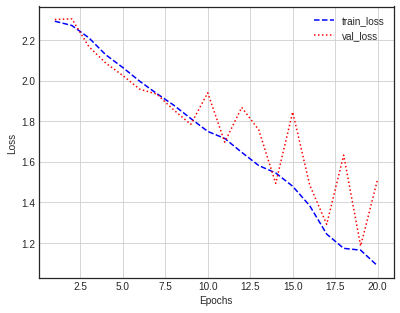

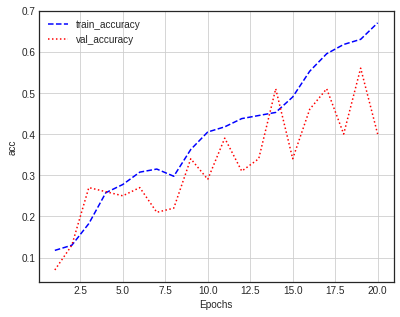

In [44]:
plot_history(history2.history)

### 논문과 유사하게 빌드

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Reshape, Conv2D, MaxPooling2D, Flatten, BatchNormalization

model = Sequential()

# Add a convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
# Add a max pooling layer with a 2x2 window
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolutional layer with 64 filters and a 3x3 kernel
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a third convolutional layer with 128 filters and a 3x3 kernel
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

# Add a reshape layer to convert the output of the convolutional layers to the input shape for the LSTM layer
model.add(Reshape((-1, 256)))

# Add an LSTM layer with 64 units
model.add(LSTM(256, return_sequences=True))
model.add(BatchNormalization())

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
# Add a dense layer with 10 units and softmax activation for classification
model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 18, 171, 64)       640       
                                                                 
 batch_normalization (BatchN  (None, 18, 171, 64)      256       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 85, 64)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 83, 64)         36928     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 83, 64)        256       
 hNormalization)                                                 
                                                      

In [20]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [21]:
# Train the model on the extracted feature vectors
# train_x, test_x, train_y, test_y
history3 = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=20, batch_size=128)

Epoch 1/20
4/4 [==============================] - 7s 410ms/step - loss: 2.5492 - accuracy: 0.3475 - val_loss: 2.6409 - val_accuracy: 0.1800
Epoch 2/20
4/4 [==============================] - 0s 35ms/step - loss: 0.7628 - accuracy: 0.8050 - val_loss: 2.4033 - val_accuracy: 0.3500
Epoch 3/20
4/4 [==============================] - 0s 36ms/step - loss: 0.3652 - accuracy: 0.9075 - val_loss: 2.7682 - val_accuracy: 0.2700
Epoch 4/20
4/4 [==============================] - 0s 36ms/step - loss: 0.3693 - accuracy: 0.9100 - val_loss: 3.1029 - val_accuracy: 0.2800
Epoch 5/20
4/4 [==============================] - 0s 35ms/step - loss: 0.2445 - accuracy: 0.9450 - val_loss: 2.9933 - val_accuracy: 0.3000
Epoch 6/20
4/4 [==============================] - 0s 37ms/step - loss: 0.1359 - accuracy: 0.9550 - val_loss: 2.9997 - val_accuracy: 0.2700
Epoch 7/20
4/4 [==============================] - 0s 35ms/step - loss: 0.0639 - accuracy: 0.9750 - val_loss: 2.9060 - val_accuracy: 0.3100
Epoch 8/20
4/4 [==========

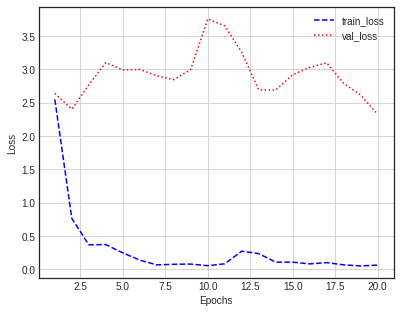

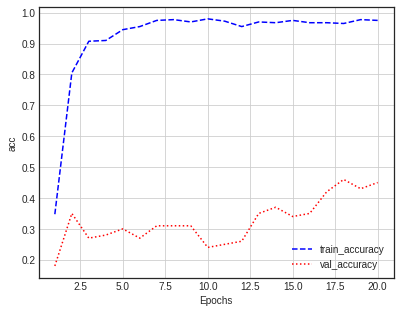

In [22]:
plot_history(history3.history)

모델이 훈련 데이터에 과적합되어 훈련 정확도와 검증 정확도 사이에 큰 차이가 발생할 수 있다. 배치 정규화를 추가하는 것은 과적합을 방지하기 위한 좋은 단계이지만 더 많은 드롭아웃을 사용하거나 모델의 복잡성을 줄이는 것과 같은 다른 기술도 시도할 수 있습니다.

train 정확도와 valid 정확도 사이의 큰 차이에 대한 또 다른 가능한 이유는 데이터 불균형 문제이다. 유효성 검사 세트의 클래스 분포가 교육 세트와 다른 경우 모델이 유효성 검사 세트에서 제대로 수행되지 않을 수 있습니다. 이 문제를 해결하기 위해 열차 테스트 분할 중에 데이터를 계층화하거나 소수 클래스를 오버샘플링할 수 있습니다.